# Вариационный автоэнкодер

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
transform = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])])

dataset = MNIST(root='./data', train=True, download=True, transform=transform)

train_size = int(len(dataset) * 0.6)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - (val_size + train_size)

generator = torch.Generator().manual_seed(42)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8)

100%|██████████| 9.91M/9.91M [00:00<00:00, 36.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.15MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.16MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
class Encoder(nn.Module):
  def __init__(self, channels, ch = 32, z = 32):
    super(Encoder, self).__init__()

    self.conv1 = nn.Conv2d(channels, ch, kernel_size=4, stride=2, padding=1)
    self.bn1 = nn.BatchNorm2d(ch)

    self.conv2 = nn.Conv2d(ch, ch * 2, kernel_size=4, stride=2, padding=1)
    self.bn2 = nn.BatchNorm2d(ch * 2)

    self.conv3 = nn.Conv2d(ch * 2, ch * 4, kernel_size=4, stride=2, padding=1)
    self.bn3 = nn.BatchNorm2d(ch * 4)

    self.conv_mu = nn.Conv2d(ch * 4, z, kernel_size=4, stride=2, padding=1)
    self.conv_logvar = nn.Conv2d(ch * 4, z, kernel_size=4, stride=1, padding=0)

  def sample(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def forward(self, x):
    x = self.bn1(self.conv1(x))
    x = torch.relu(x)

    x = self.bn2(self.conv2(x))
    x = torch.relu(x)

    x = self.bn3(self.conv3(x))
    x = torch.relu(x)

    mu = self.conv_mu(x)
    logvar = self.conv_logvar(x)

    z = self.sample(mu, logvar)

    return z, mu, logvar

In [5]:
class Decoder(nn.Module):
  def __init__(self, channels, ch=32, z=32):
      super(Decoder, self).__init__()

      self.conv1 = nn.ConvTranspose2d(z, ch * 4, kernel_size=4, stride=2, padding=1)
      self.bn1 = nn.BatchNorm2d(ch * 4)

      self.conv2 = nn.ConvTranspose2d(ch * 4, ch * 2, kernel_size=4, stride=2, padding=1)
      self.bn2 = nn.BatchNorm2d(ch * 2)

      self.conv3 = nn.ConvTranspose2d(ch * 2, ch, kernel_size=4, stride=2, padding=1)
      self.bn3 = nn.BatchNorm2d(ch)

      self.conv4 = nn.ConvTranspose2d(ch, channels, kernel_size=4, stride=2, padding=1)

  def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = torch.relu(x)

        x = self.bn2(self.conv2(x))
        x = torch.relu(x)

        x = self.bn3(self.conv3(x))
        x = torch.relu(x)

        x = self.conv4(x)
        x = torch.tanh(x)

        return x


In [6]:
class VAE(nn.Module):
  def __init__(self, channels_in, ch=16, z=32):
    super(VAE, self).__init__()
    self.encoder = Encoder(channels=channels_in, ch=ch, z=z)
    self.decoder = Decoder(channels=channels_in, ch=ch, z=z)

  def forward(self, x):
    encoding, mu, logvar = self.encoder(x)

    if self.training:
      x_recon = self.decoder(encoding)
    else:
      x_recon = self.decoder(mu)

    return x_recon, mu, logvar

In [17]:
def vae_loss(recon, x, mu, logvar):
  recon_loss = F.mse_loss(recon, x, reduction='mean')
  kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
  loss = recon_loss + 0.1 * kl_loss
  return loss

def psnr(recon, target, max_val=1.0):
    mse = F.mse_loss(recon, target, reduction='mean')
    if mse == 0:
        return torch.tensor(100.0)
    return 20 * torch.log10(max_val / torch.sqrt(mse))

def add_noise(images, noise_factor=0.2):
  noisy = images + noise_factor * torch.randn_like(images)
  noisy = torch.clamp(noisy, -1., 1.)
  return noisy

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(channels_in=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

patience = 3
best_val_loss = float("inf")
patience_counter = 0
model_path = "best_vae_model.pth"


for epoch in range(epochs):
    model.train()
    running_loss, running_psnr = 0.0, 0.0

    for clean_images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        clean_images = clean_images.to(device)
        noisy_images = add_noise(clean_images)

        optimizer.zero_grad()
        outputs, mu, logvar = model(noisy_images)
        loss = vae_loss(outputs, clean_images, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_psnr += psnr(outputs, clean_images).item()

    train_loss = running_loss / len(train_loader)
    train_psnr = running_psnr / len(train_loader)

    model.eval()
    val_loss_total, val_psnr = 0.0, 0.0
    with torch.no_grad():
        for clean_images, _ in val_loader:
            clean_images = clean_images.to(device)
            noisy_images = add_noise(clean_images)
            outputs, mu, logvar = model(noisy_images)

            loss = vae_loss(outputs, clean_images, mu, logvar)
            val_loss_total += loss.item()
            val_psnr += psnr(outputs, clean_images).item()

    val_loss_avg = val_loss_total / len(val_loader)
    val_psnr_avg = val_psnr / len(val_loader)

    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | PSNR: {train_psnr:.2f}")
    print(f"Val   Loss: {val_loss_avg:.4f} | PSNR: {val_psnr_avg:.2f}")

    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        patience_counter = 0
        torch.save(model.state_dict(), model_path)
        print(f"✔ Model improved. Saved to {model_path}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏹ Early stopping triggered!")
            break

model.load_state_dict(torch.load(model_path))
model.eval()
test_loss, test_psnr = 0.0, 0.0

with torch.no_grad():
    for clean_images, _ in test_loader:
        clean_images = clean_images.to(device)
        noisy_images = add_noise(clean_images)
        outputs, mu, logvar = model(noisy_images)

        test_loss += vae_loss(outputs, clean_images, mu, logvar).item()
        test_psnr += psnr(outputs, clean_images).item()

test_loss /= len(test_loader)
test_psnr /= len(test_loader)

print("\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"PSNR Score: {test_psnr:.2f} dB")

Epoch 1/10: 100%|██████████| 563/563 [00:49<00:00, 11.28it/s]



Epoch 1/10
Train Loss: 0.0746 | PSNR: 13.14
Val   Loss: 0.0302 | PSNR: 16.26
✔ Model improved. Saved to best_ae_model.pth


Epoch 2/10: 100%|██████████| 563/563 [00:53<00:00, 10.55it/s]



Epoch 2/10
Train Loss: 0.0279 | PSNR: 16.50
Val   Loss: 0.0214 | PSNR: 17.79
✔ Model improved. Saved to best_ae_model.pth


Epoch 3/10: 100%|██████████| 563/563 [00:47<00:00, 11.85it/s]



Epoch 3/10
Train Loss: 0.0223 | PSNR: 17.47
Val   Loss: 0.0194 | PSNR: 18.19
✔ Model improved. Saved to best_ae_model.pth


Epoch 4/10: 100%|██████████| 563/563 [00:48<00:00, 11.50it/s]



Epoch 4/10
Train Loss: 0.0197 | PSNR: 18.00
Val   Loss: 0.0175 | PSNR: 18.56
✔ Model improved. Saved to best_ae_model.pth


Epoch 5/10: 100%|██████████| 563/563 [00:47<00:00, 11.91it/s]



Epoch 5/10
Train Loss: 0.0182 | PSNR: 18.33
Val   Loss: 0.0156 | PSNR: 19.14
✔ Model improved. Saved to best_ae_model.pth


Epoch 6/10: 100%|██████████| 563/563 [00:47<00:00, 11.95it/s]



Epoch 6/10
Train Loss: 0.0171 | PSNR: 18.57
Val   Loss: 0.0152 | PSNR: 19.22
✔ Model improved. Saved to best_ae_model.pth


Epoch 7/10: 100%|██████████| 563/563 [00:47<00:00, 11.83it/s]



Epoch 7/10
Train Loss: 0.0160 | PSNR: 18.86
Val   Loss: 0.0147 | PSNR: 19.31
✔ Model improved. Saved to best_ae_model.pth


Epoch 8/10: 100%|██████████| 563/563 [00:47<00:00, 11.76it/s]



Epoch 8/10
Train Loss: 0.0154 | PSNR: 19.03
Val   Loss: 0.0127 | PSNR: 20.02
✔ Model improved. Saved to best_ae_model.pth


Epoch 9/10: 100%|██████████| 563/563 [00:47<00:00, 11.79it/s]



Epoch 9/10
Train Loss: 0.0148 | PSNR: 19.18
Val   Loss: 0.0134 | PSNR: 19.68


Epoch 10/10: 100%|██████████| 563/563 [00:47<00:00, 11.78it/s]



Epoch 10/10
Train Loss: 0.0143 | PSNR: 19.33
Val   Loss: 0.0124 | PSNR: 20.07
✔ Model improved. Saved to best_ae_model.pth

Test Results:
Test Loss: 0.0124
PSNR Score: 20.07 dB


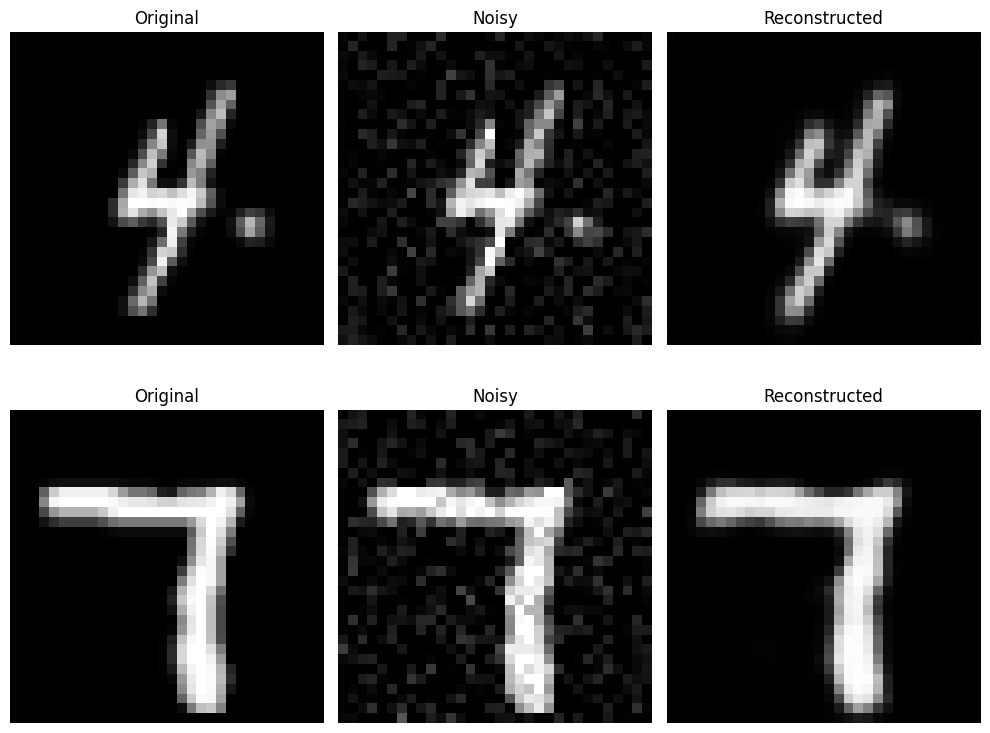

In [19]:
def show_images(orig, noisy, recon, n=1):
    orig = orig[:n].cpu().squeeze(1)
    noisy = noisy[:n].cpu().squeeze(1)
    recon = recon[:n].cpu().squeeze(1)

    fig, axes = plt.subplots(n, 3, figsize=(10, 4 * n))
    if n == 1:
        axes = [axes]
    for i in range(n):
        axes[i][0].imshow(orig[i], cmap='gray')
        axes[i][0].set_title("Original")
        axes[i][0].axis('off')

        axes[i][1].imshow(noisy[i], cmap='gray')
        axes[i][1].set_title("Noisy")
        axes[i][1].axis('off')

        axes[i][2].imshow(recon[i], cmap='gray')
        axes[i][2].set_title("Reconstructed")
        axes[i][2].axis('off')
    plt.tight_layout()
    plt.show()

with torch.no_grad():
    clean_images, _ = next(iter(val_loader))
    clean_images = clean_images.to(device)
    noisy_images = add_noise(clean_images)
    outputs, _, _ = model(noisy_images)
    show_images(clean_images, noisy_images, outputs, n=2)

In [20]:
from google.colab import files
files.download("best_ae_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>